In [1]:
! pip install pyarrow matplotlib sentencepiece pandas opencv-python
import torch
import os
import cv2
import sys
import numpy as np
import math
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerDecoder, TransformerDecoderLayer
import sentencepiece as spm
import matplotlib.pyplot as plt
import multiprocessing
import time
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

if torch.backends.mps.is_available():  # Check for Apple Silicon GPU availability (requires PyTorch 1.12 or later)
    device = torch.device("mps")
elif torch.cuda.is_available():  # Check for NVIDIA GPU availability
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")  # Fall back to CPU

print(f"Using device: {device}")


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Using device: cuda


Dataset Import

In [2]:
# Read data from both Parquet files
# train_0 = pd.read_parquet('../dataset/0000.parquet')
# train_1 = pd.read_parquet('../dataset/0001.parquet')
# train_2 = pd.read_parquet('../dataset/0002.parquet')
# train_3 = pd.read_parquet('../dataset/0003.parquet')
# train_4 = pd.read_parquet('../dataset/0004.parquet')
# train_5 = pd.read_parquet('../dataset/0005.parquet')
# train_6 = pd.read_parquet('../dataset/0006.parquet')
# train_7 = pd.read_parquet('../dataset/0007.parquet')
# train_8 = pd.read_parquet('../dataset/0008.parquet')

# train = pd.concat([train_0, train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8,], ignore_index=True)
# train = train.reset_index(drop=True)

# print(train.shape)
# print(train[:2])
# train = train.iloc[:100]

In [3]:
sp = spm.SentencePieceProcessor()
sp.Load('../dataset/spm_10000_vocab_model.model')

True

Dataset

In [21]:
class CaptionDataset(Dataset):
    def __init__(self, data_file_path, image_side, patch_side, sp,  device, validate = False):
        super().__init__()
        self.sp = sp
        if validate == True:
            self.data = pd.read_parquet(data_file_path) [:100]
        else:
            self.data = pd.read_parquet(data_file_path)
        self.dataset = []
        self.device = device

        for row in self.data.itertuples():
            image = self.tranformImageForPatching(row.image, image_side, patch_side)
            patches = self.patchImage(image, image_side, patch_side)
            imageTokens = self.patchesToTokens(patches)

            for caption in row.caption:
                self.dataset.append([
                    row.image,  
                    imageTokens, 
                    caption,
                ])
    
    def tranformImageForPatching(self, image, image_side, patch_side):
        image_pxl = cv2.imdecode(np.frombuffer(image['bytes'], np.uint8), cv2.IMREAD_COLOR)
        image_pxl = cv2.cvtColor(image_pxl, cv2.COLOR_BGR2RGB)
        cropped_image = self.cropImage(image_pxl)
        # padded_image = self.addPadding(image_pxl, patch_side)

        resized_image = cv2.resize(cropped_image,  (image_side, image_side), interpolation=cv2.INTER_AREA)        

        return resized_image
    
    def addPadding(self, image, patch_side):
        ## For flaxible tokens amount
        # padded_height = ((image.shape[0] // patch_side) + 1) * patch_side
        # padded_width = ((image.shape[1] // patch_side) + 1) * patch_side
        # padded_image = cv2.copyMakeBorder(image, 0, padded_height - image.shape[0], 0, padded_width - image.shape[1], cv2.BORDER_REFLECT)
        
        # Get dimensions of the image
        height, width = image.shape[:2]
        pad_size = max(width, height)
        delta_w = pad_size - width
        delta_h = pad_size - height
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # Pad the image with black color (0, 0, 0) BORDER_CONSTANT
        image_padded = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        return image_padded
    
    def cropImage(self, image):
          # Get the dimensions of the image
        height, width = image.shape[:2]
        side_length = min(height, width)

        # Calculate coordinates to crop the central square
        top = (height - side_length) // 2
        left = (width - side_length) // 2
        bottom = top + side_length
        right = left + side_length

        # Crop the central square
        cropped_image = image[top:bottom, left:right]
        return cropped_image
    
    def patchImage(self, image, image_side, patch_side):
        patches = []
        for y in range(0, image_side, patch_side):
            for x in range(0, image_side, patch_side):
                # Extract the block
                block = image[y:y+patch_side, x:x+patch_side]
                patches.append(block)
 
        return patches
    
    def patchesToTokens(self, patches):
        tokens = []
        for patch in patches:
            patch_tensor = torch.tensor(patch, device = self.device).permute(2, 0, 1).float()  # CHW format
            normalized_patch = patch_tensor / 255.0
            normalized_patch = normalized_patch.reshape(-1)
            tokens.append(normalized_patch)
        return torch.stack(tokens, dim=0)
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        imageTokens = self.dataset[idx][1]
        caption_input  = torch.tensor([sp.PieceToId('<s>')] + self.sp.EncodeAsIds(self.dataset[idx][2]), dtype=torch.long, device = self.device)
        caption_target = torch.tensor(self.sp.EncodeAsIds(self.dataset[idx][2]) + [sp.PieceToId('</s>')], dtype=torch.long, device = self.device)
        return image, imageTokens, caption_input, caption_target

Padding Function

In [5]:
def collate_fn(batch):
    image, imagesTokens, captionsInputs, captionsTargets = zip(*batch)  # Unzip the batch into inputs and targets
    inputs_padded = pad_sequence(captionsInputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(captionsTargets, batch_first=True, padding_value=0)
    return image, torch.stack(imagesTokens, dim=0), inputs_padded, targets_padded

Model

In [6]:
class Head(nn.Module):
    def __init__(self, embed_size, head_size, dropout, device):
        super().__init__()
        self.head_size      = head_size
        self.embed_size     = embed_size
        self.device         = device
        
        self.Key   = nn.Linear(self.embed_size, self.head_size, bias=False, device = self.device) # Size: [embed_size x head_size]
        self.Query = nn.Linear(self.embed_size, self.head_size, bias=False, device = self.device) # Size: [embed_size x head_size] 
        self.Value = nn.Linear(self.embed_size, self.head_size, bias=False, device = self.device) # Size: [embed_size x head_size] 
        
        self.Dropout = nn.Dropout(dropout)
        
    def forward(self, q, k , v, dont_look_ahead = True, padding_mask = None):
        batchSize, tokens, head_size = q.shape
        query = self.Query(q)  # Size: [batchSize x tokens x head_size]
        key   = self.Key(k)    # Size: [batchSize x tokens x head_size]
        value = self.Value(v)  # Size: [batchSize x tokens x head_size]

        tril = torch.tril(torch.ones(tokens, tokens, device = self.device))               # Size: [tokens_amount x tokens_amount]. Diagonale ones left side only.                                                                      

        # Compute Attention scores ("Affinities")
        attention = query @ key.transpose(-2, -1) * head_size**0.5                        # [Batch Size x Tokens amount x head_size] @ [Batch Size x head_size x Tokens amount] --> [Batch Size x Tokens amount x Tokens amount]

        if padding_mask is not None:
            attention = attention.masked_fill(padding_mask == 0, float(-1e9))           # Size: [batchSize x tokens x tokens]
        if dont_look_ahead == True :
            attention = attention.masked_fill(tril[:tokens, :tokens] == 0, float(-1e9)) # Size: [batchSize x tokens x tokens]
        
        attention = F.softmax(attention, dim=-1)                                          # Size: [batchSize x tokens x tokens]
        attention = self.Dropout(attention)
        
        out = attention @ value                                                           # Size: [Batch Size x Tokens Amount x head_size]
        return out                                                                        # Size: [Batch Size x Tokens Amount x head_size]
    
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads, head_size, dropout, device):
        super().__init__()  
        self.num_heads  = num_heads
        self.head_size  = head_size
        self.embed_size = embed_size 
        self.device     = device
        
        self.Heads = nn.ModuleList()
        for _ in range(num_heads):
            self.Heads.append(Head(self.embed_size, self.head_size, dropout, self.device)) # ModuleList Size: [num_heads]

        self.Projection = nn.Linear(self.embed_size, self.embed_size)    # Size: [Batch Size x Tokens Amount x embed_size]
        self.Dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, dont_look_ahead = True, mask=None):
        multiHead = torch.cat([head(q, k, v, dont_look_ahead, mask) for head in self.Heads], dim=-1)  # Size: [Batch Size x Tokens Amount x embed_size]
        projection = self.Dropout(self.Projection(multiHead))            # Size: [Batch Size x Tokens Amount x embed_size]
        return projection                                                # Size: [Batch Size x Tokens Amount x embed_size]

class FeedForward(nn.Module):
    def __init__(self, embed_size, dropout):
        super().__init__()
        self.FeedForward = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),  # Size: [Batch Size x Tokens Amount x embed_size]
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),  # Size: [Batch Size x Tokens Amount x embed_size]
            nn.Dropout(dropout)
        )
    
    def forward(self, attentions):
        return self.FeedForward(attentions)
    
class DecoderBlock(nn.Module):
    def __init__(self,  embed_size, num_heads, head_size, dropout, device):
        super().__init__()
        self.embed_size = embed_size
        self.num_heads  = num_heads
        self.head_size  = head_size
        self.device     = device

        self.MultiAttentionHeads = MultiHeadAttention(self.embed_size, self.num_heads, self.head_size, dropout, self.device) # Size: [Batch Size x Tokens Amount x head_size]
        self.FeedForward         = FeedForward(self.embed_size, dropout)   # Size: [Batch Size x Tokens Amount x head_size]
        self.Ln1                 = nn.LayerNorm(self.embed_size)  # Size: [Batch Size x Tokens Amount x head_size]
        self.Ln2                 = nn.LayerNorm(self.embed_size)  # Size: [Batch Size x Tokens Amount x head_size]
        self.Ln3                 = nn.LayerNorm(self.embed_size)  # Size: [Batch Size x Tokens Amount x head_size]

    def forward(self, captionPositionedEmbeddings, encoderK, encoderV, mask=None):

        captionQ = captionK = captionV = self.Ln1(captionPositionedEmbeddings)
        captionAttentions  = captionPositionedEmbeddings + self.MultiAttentionHeads(captionQ, captionK, captionV, dont_look_ahead = True, mask=mask) # Size: [Batch Size x Tokens Amount x embed_size]. Apply MultiHead Attention Layer

        decoderQ = self.Ln2(captionAttentions)
        encoderK = self.Ln2(encoderK) 
        encoderV = self.Ln2(encoderV)

        mergedAttentions  = decoderQ + self.MultiAttentionHeads(decoderQ, encoderK, encoderV, dont_look_ahead = False, mask=None)
        feedForward = mergedAttentions + self.FeedForward(self.Ln3(mergedAttentions))       # Size: [Batch Size x Tokens Amount x embed_size]
        return feedForward                                                                  # Size: [Batch Size x Tokens Amount x embed_size]

class EncoderBlock(nn.Module):
    def __init__(self,  embed_size, num_heads, head_size, dropout, device):
        super().__init__()
        self.embed_size = embed_size
        self.num_heads  = num_heads
        self.head_size  = head_size
        self.device     = device

        self.MultiAttentionHeads = MultiHeadAttention(self.embed_size, self.num_heads, self.head_size, dropout, self.device) # Size: [Batch Size x Tokens Amount x head_size]
        self.FeedForward         = FeedForward(self.embed_size, dropout)   # Size: [Batch Size x Tokens Amount x head_size]
        self.Ln1                 = nn.LayerNorm(self.embed_size)  # Size: [Batch Size x Tokens Amount x head_size]
        self.Ln2                 = nn.LayerNorm(self.embed_size)  # Size: [Batch Size x Tokens Amount x head_size]

    def forward(self, positionedEmbeddings, mask=None):
        imageQ = imageK = imageV  = self.Ln1(positionedEmbeddings)
        attentions  = positionedEmbeddings + self.MultiAttentionHeads(imageQ, imageK, imageV, dont_look_ahead = False, mask=None) # Size: [Batch Size x Tokens Amount x embed_size]. Apply MultiHead Attention Layer
        feedForward = attentions + self.FeedForward(self.Ln2(attentions))                                                         # Size: [Batch Size x Tokens Amount x embed_size]
        return feedForward           

class Encoder(nn.Module):
    def __init__(self, num_blocks, num_heads, embed_size, head_size, image_side, patch_side, dropout, device):
        super().__init__()
        self.device                 = device
        self.embed_size             = embed_size
        self.num_blocks             = num_blocks
        self.num_heads              = num_heads
        self.head_size              = head_size
        self.image_side             = image_side
        self.patch_side             = patch_side
        
        pathcesEmbeddingInputSize = patch_side**2 * 3
        self.pathcesEmbedding = nn.Linear(pathcesEmbeddingInputSize, embed_size)
        self.EncoderBlocks = nn.ModuleList([
            EncoderBlock(self.embed_size, self.num_heads, self.head_size, dropout, self.device) for _ in range(self.num_blocks)
        ])
        self.final_layer_norm = nn.LayerNorm(self.embed_size)
    
    def positionEncoding(self, input_tokens_amount):
        positionEncoding = torch.zeros(input_tokens_amount, self.embed_size, device = self.device)                                       # max length x embedding dimmensions equivalent to Size: [input_tokens_amount x embed_size]
        positions = torch.arange(0, input_tokens_amount, dtype=torch.float, device = self.device).unsqueeze(1)                           # Tensor [0, 1, 2,..., input_tokens_amount] -> [⋮] : rotated for each value in separate row of 1 column
        div_term = torch.exp(torch.arange(0, self.embed_size, 2, device = self.device).float() * (-math.log(10000.0) / self.embed_size)) # Tensor [0, 2, 4,..., embed_size] x (-math.log(10000.0) / self.embed_size) --> exponenta

        positionEncoding[:, 0::2] = torch.sin(positions * div_term)        # Size: [input_tokens_amount x embed_size], set the odd values (columns 1 and 3) 
        positionEncoding[:, 1::2] = torch.cos(positions * div_term)        # Size: [input_tokens_amount x embed_size], set the even values (columns 2 and 4) 
 
        return positionEncoding.unsqueeze(0)                               # Size: [1 (for batch dim) x input_tokens_amount x embed_size]
     
    def forward(self, imagesTokens):
        # imagesTokens   Size: [Batch Size x Image Tokens Amount x patch_side**2 * 3]       
        
        batchSize, imageTokensAmount, _ = imagesTokens.shape
        imageEmbedding = self.pathcesEmbedding(imagesTokens)                                   # Size [Batch Size  x Image Tokens Amount x embed_size]
        imagePositionedEmbeddings = imageEmbedding + self.positionEncoding(imageTokensAmount)  # Size [Batch Size  x Image Tokens Amount x embed_size]

        imageBlocks = imagePositionedEmbeddings
        for block in self.EncoderBlocks:
            imageBlocks = block(imageBlocks, mask = None)  # Size: [Batch Size x Image Tokens Amount x embed_size]
        encoderOut = self.final_layer_norm(imageBlocks)    # Size: [Batch Size x Image Tokens Amount x embed_size]

        return encoderOut                                  # Size: [Batch Size x Image Tokens Amount x embed_size]

class Decoder(nn.Module):
    def __init__(self, num_blocks, num_heads, embed_size, head_size,  vocab_size, dropout, device):
        super().__init__()
        self.device                 = device
        self.num_blocks             = num_blocks
        self.embed_size             = embed_size
        self.vocab_size             = vocab_size
        self.num_heads              = num_heads
        self.head_size              = head_size

        self.captionEmbedding = torch.nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size, device = self.device) # Size: [vocab_size x embed_size]
        self.DecoderBlocks = nn.ModuleList([
            DecoderBlock(self.embed_size, self.num_heads, self.head_size, dropout, self.device) for _ in range(self.num_blocks)
        ])
        self.decoder_final_layer_norm = nn.LayerNorm(self.embed_size)
        self.LangModelHead  = nn.Linear(self.embed_size, self.vocab_size, device = self.device) # Size: [embed_size x vocab_size]
    
    def positionEncoding(self, input_tokens_amount):
        positionEncoding = torch.zeros(input_tokens_amount, self.embed_size, device = self.device)                                  # max length x embedding dimmensions equivalent to Size: [input_tokens_amount x embed_size]
        positions = torch.arange(0, input_tokens_amount, dtype=torch.float, device = self.device).unsqueeze(1)                      # Tensor [0, 1, 2,..., input_tokens_amount] -> [⋮] : rotated for each value in separate row of 1 column
        div_term = torch.exp(torch.arange(0, self.embed_size, 2, device = self.device).float() * (-math.log(10000.0) / self.embed_size)) # Tensor [0, 2, 4,..., embed_size] x (-math.log(10000.0) / self.embed_size) --> exponenta

        positionEncoding[:, 0::2] = torch.sin(positions * div_term)        # Size: [input_tokens_amount x embed_size], set the odd values (columns 1 and 3) 
        positionEncoding[:, 1::2] = torch.cos(positions * div_term)        # Size: [input_tokens_amount x embed_size], set the even values (columns 2 and 4) 
 
        return positionEncoding.unsqueeze(0)                               # Size: [1 (for batch dim) x input_tokens_amount x embed_size]
     
    def forward(self, captionsInputs, encoderK, encoderV):
        # captionsInputs Size: [Batch Size x Tokens Amount]
    
        batchSize, captionTokensAmount = captionsInputs.shape

        caption_padding_lables = (captionsInputs != 0).float().to(device)
        caption_padding_mask = caption_padding_lables.unsqueeze(-1) @ caption_padding_lables.unsqueeze(-2)

        captionEmbeddings = self.captionEmbedding(captionsInputs)                              # Size: [Batch Size x Tokens Amount x embed_size]
        positionedEmbeddings = captionEmbeddings + self.positionEncoding(captionTokensAmount)  # Size: [Batch Size x Tokens Amount x embed_size]
        
        decoderInput = positionedEmbeddings
        for block in self.DecoderBlocks:
            decoderInput = block(decoderInput, encoderK, encoderV, mask = caption_padding_mask)        # Size: [Batch Size x Tokens Amount x embed_size]
        decoderOut = self.decoder_final_layer_norm(decoderInput)
        
        logits = self.LangModelHead(decoderOut)                            # Size: [Batch Size x Tokens Amount x vocab_size]
        return logits                                                      # Size: [Batch Size x Tokens Amount x vocab_size]

class captionTransformer(nn.Module):
    def __init__(self, num_blocks, num_heads, embed_size, head_size, vocab_size, image_side, patch_side, dropout, device):
        super().__init__()
        self.device                 = device
        self.num_blocks             = num_blocks
        self.embed_size             = embed_size
        self.vocab_size             = vocab_size
        self.num_heads              = num_heads
        self.head_size              = head_size
        self.image_side             = image_side
        self.patch_side             = patch_side
        
        self.Encoder = Encoder(num_blocks, num_heads, embed_size, head_size, image_side, patch_side, dropout, device)
        self.Decoder = Decoder(num_blocks, num_heads, embed_size, head_size, vocab_size, dropout, device)
      
    def forward(self, imagesTokens, captionsInputs):
        # captionsInputs Size: [Batch Size x Tokens Amount]
        # imagesTokens   Size: [Batch Size x Image Tokens Amount x patch_side**2 * 3]       
        
        # print("Encoder:")
        encoderK = encoderV = self.Encoder(imagesTokens)            # Size: [Batch Size x Image Tokens Amount x embed_size]
        # print("Decoder:")
        logits = self.Decoder(captionsInputs, encoderK, encoderV)  # Size: [Batch Size x Caption Tokens Amount x vocab_size]
        return logits                                               # Size: [Batch Size x Caption Tokens Amount x vocab_size]

In [7]:
# Embedd = nn.Embedding(10, 2)
# input_indices = torch.tensor([
#     [1, 1, 1, 1],
#     [1, 1, 1, 0],  # Using '0' as padding
#     [1, 0, 0, 0]   # More padding examples
# ])

# print("Input:\n",input_indices.shape)
# print(input_indices, "\n")

# padding_lable = (input_indices != 0).int()
# print("Padding mask:\n", padding_lable.shape)
# print(padding_lable, "\n")

# padding_mask_A = padding_lable.unsqueeze(-1)
# print("unsqueeze(-1) Padding mask:\n", padding_mask_A.shape)
# padding_mask_B = padding_lable.unsqueeze(-2)
# print("unsqueeze(-2) Padding mask:\n", padding_mask_B.shape)

# padding_mask = padding_mask_A @ padding_mask_B

# print("Dot product Padding mask:\n", padding_mask.shape)
# print(padding_mask, "\n")

# embedded = Embedd(input_indices)
# print("embedded input:\n", embedded.shape)
# # print(embedded, "\n")

# attention = embedded @ embedded.transpose(-2, -1)
# print("embedded.transpose(-2, -1) :\n",embedded.transpose(-2, -1).shape)
# print("attention :\n",attention.shape)
# print(attention)

# attention = attention.masked_fill(padding_mask == 0, float('-inf')) 
# print("padded attention :\n", attention.shape)
# print(attention)
# soft  = F.softmax(attention, dim=-1) 
# print("padded attention soft :\n", soft.shape)
# print(soft)

In [8]:
# print(torch.tril(torch.ones(2, 2)))

# p = torch.tensor([1,1,0,0]).float()
# p1 = p.unsqueeze(-1)
# p2 = p.unsqueeze(-2)
# print(p)
# print(p1)
# print(p2)
# mask = p1 @ p2
# print(mask)

Parameters

In [27]:

batch_size = 32
learning_rate = 3e-5
dropout = 0.2
maxNewTokens = 100
vocab_size = sp.GetPieceSize()
embed_size = 512 # 512
num_blocks = 6
num_heads = 8 # 8
head_size = int(embed_size / num_heads)
print("head_size: ", head_size)
if embed_size % num_heads != 0:
    print("embed_size Cannot be divided evenly by num_heads.")
    sys.exit()
image_side = 256
patch_side = 16
if image_side % patch_side != 0:
    print("image_side Cannot be divided evenly by patch_side.")
    sys.exit()

data = [
    # '../dataset/0000.parquet',
    '../dataset/0001.parquet',
    '../dataset/0002.parquet',
    # '../dataset/0003.parquet',
    # '../dataset/0004.parquet',
    # '../dataset/0005.parquet',
    # '../dataset/0006.parquet',
    # '../dataset/0007.parquet',
]

validation_data = [
    '../dataset/0001.parquet',
]

head_size:  64


Model and Dataloader

In [10]:
model = captionTransformer(
    embed_size          = embed_size, 
    num_blocks          = num_blocks,
    num_heads           = num_heads,
    head_size           = head_size, 
    vocab_size          = vocab_size,
    image_side          = image_side,
    patch_side          = patch_side,
    dropout             = dropout,
    device              = device,
)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
datasets = []
for file in data:
    print("File started : ", file, datetime.datetime.now())
    captionDataset = CaptionDataset(file, image_side, patch_side, sp, device)
    datasets.append(captionDataset)
    print("Preprocessing finished: ", datetime.datetime.now())

File started :  ../dataset/0001.parquet 2024-04-12 11:12:02.878941
Preprocessing finished:  2024-04-12 11:14:17.771656
File started :  ../dataset/0002.parquet 2024-04-12 11:14:17.771848
Preprocessing finished:  2024-04-12 11:16:32.505431


In [42]:
import datetime

epochs = 15
print("Training started at:", datetime.datetime.now())

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for ds in datasets:
        print("Dataloader started : ", datetime.datetime.now())
        captionDataloader = DataLoader(ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,)
        print("Dataloader finished: ", datetime.datetime.now())
        for batch_idx, (image, imagesTokens, captionsInputs, captionsTargets) in enumerate(captionDataloader):
            logits  = model(imagesTokens, captionsInputs)                     # Size: [Batch Size x Caption Tokens Amount x vocab_size]
            
            batchSize, captionTokensAmount, vocabSize = logits.shape
            
            logits  = logits.view(batchSize * captionTokensAmount, vocabSize) # Size: [(Batch Size * captionTokensAmount) x Vocab Size]
            targets = captionsTargets.view(batchSize * captionTokensAmount)   # Size: [(Batch Size * captionTokensAmount)]
            
            mask = targets != 0  # Assuming -1 is used for padding in labels
            loss = F.cross_entropy(logits, targets, reduction='none')
            loss = loss * mask.view(batchSize * captionTokensAmount).float()
            loss = loss.sum() / mask.sum()
            running_loss += loss.item()
            
            # loss = F.cross_entropy(logits, targets)
            optimizer.zero_grad(set_to_none = True)
            # optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (batch_idx+1) % 10 == 0:  # Print loss every 100 batches
                print(f'[{epoch + 1}, {batch_idx + 1}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0
                # print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    for file in validation_data:
        print("Eval started : ", file, datetime.datetime.now())
        valid_captionDataset = CaptionDataset(file, image_side, patch_side, sp, device, True)
        valid_captionDataloader = DataLoader(valid_captionDataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,)
        print("Eval preprocess finished : ", datetime.datetime.now())
        val_running_loss = 0.0
        with torch.no_grad():  # No gradient is needed for validation
            for batch_idx, (image, imagesTokens, captionsInputs, captionsTargets) in enumerate(valid_captionDataloader):
                logits  = model(imagesTokens, captionsInputs)                     # Size: [Batch Size x Caption Tokens Amount x vocab_size]
            
                batchSize, captionTokensAmount, vocabSize = logits.shape
                
                logits  = logits.view(batchSize * captionTokensAmount, vocabSize) # Size: [(Batch Size * captionTokensAmount) x Vocab Size]
                targets = captionsTargets.view(batchSize * captionTokensAmount)   # Size: [(Batch Size * captionTokensAmount)]
                
                mask = targets != 0  # Assuming -1 is used for padding in labels
                loss = F.cross_entropy(logits, targets, reduction='none')
                loss = loss * mask.view(batchSize * captionTokensAmount).float()
                loss = loss.sum() / mask.sum()
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(valid_captionDataloader)
        print(f'Epoch {epoch + 1} validation loss: {val_loss:.3f}')
print("finish")

Training started at: 2024-04-12 12:23:51.344395
Dataloader started :  2024-04-12 12:23:51.351373
Dataloader finished:  2024-04-12 12:23:51.351508
[1, 10] loss: 3.756
[1, 20] loss: 3.619
[1, 30] loss: 3.900
[1, 40] loss: 3.681
[1, 50] loss: 3.798
[1, 60] loss: 3.912
[1, 70] loss: 3.906
[1, 80] loss: 3.821
[1, 90] loss: 3.707
[1, 100] loss: 3.813
[1, 110] loss: 3.902
[1, 120] loss: 3.785
[1, 130] loss: 3.796
[1, 140] loss: 3.717
[1, 150] loss: 3.800
[1, 160] loss: 3.744
[1, 170] loss: 3.915
[1, 180] loss: 3.718
[1, 190] loss: 3.770
[1, 200] loss: 3.640
[1, 210] loss: 3.802
[1, 220] loss: 3.845
[1, 230] loss: 3.775
[1, 240] loss: 3.722
[1, 250] loss: 3.689
[1, 260] loss: 3.747
[1, 270] loss: 3.985
[1, 280] loss: 3.739
[1, 290] loss: 3.733
[1, 300] loss: 3.730
[1, 310] loss: 3.878
[1, 320] loss: 3.847
[1, 330] loss: 3.920
[1, 340] loss: 3.751
[1, 350] loss: 3.875
[1, 360] loss: 3.698
[1, 370] loss: 3.833
[1, 380] loss: 3.656
[1, 390] loss: 3.817
[1, 400] loss: 3.774
[1, 410] loss: 3.738
[1

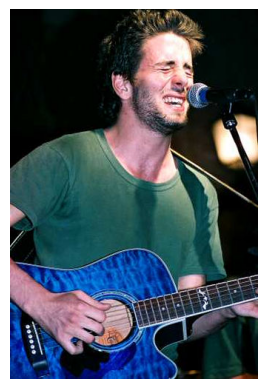

Caption # 0 :  <unk>s<unk> people having a guitar.</s>.</s> in safety.</s> protest.</s>.</s>is flame in a loft.</s> shop.</s> range.</s>,IL.</s>, unhappy.</s>.</s> door, dressed in black, having plan taking a picture into old.</s> in a hot.</s>.</s>.</s> the water.</s> home store.</s> wearing black wedding one man with light.</s>.</s> looks at the microphone.</s>.</s> white door.</s>.</s>ing handle. 


Caption # 1 :  <unk>s<unk> men move to music each other players red and laughing.</s> in air.</s>st in front of them.</s> cars of a building.</s>ul.</s> game.</s>.</s>.</s>ro.</s> behind them.</s>.</s> of the street</s>.</s>.</s> of a vehicle.</s> team lot.</s>.</s> at the foreground.</s> road.</s> and one woman who has a night</s> on the background.</s> eye.</s> on it.</s> looking at an apron. 


Caption # 2 :  <unk>s<unk> people high are walking in the kneeling.</s>.</s>.</s> other are standing behind them.</s>ing a protest shapeI.</s> hill.</s> in the rest, one in a school.</s>.</s>.<

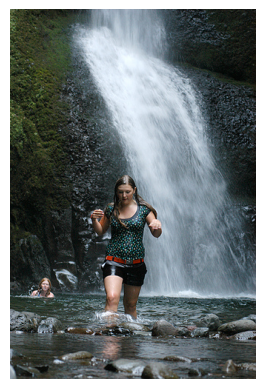

Caption # 0 :  <unk>s<unk> grinding as three people stand on a steep</s>.</s> boat.</s> in a plane that is fir.</s>.</s>.</s> scarf and three.</s> that's of a crowd.</s>.</s> on a row of leaves.</s>.</s>ing out a lake.</s> of his arms on the sameing photographed.</s> in a gondola.</s> building.</s>.</s> entertain.</s>.</s>.</s> with a machete.</s> building.</s> and gray bike.</s>.</s>.</s> 


Caption # 1 :  <unk>s<unk>arious to make a table in the snow.</s>.</s> with a woman in the suning watched.</s>.</s>.</s> along side"s and Bus.</s> stand in the other dancing in a photo stares.</s> man with another woman wearing sea.</s>.</s> floor.</s> cart.</s> nearby.</s> for the man is wearing red shirt.</s>.</s>.</s>.</s> movement a street.</s> friende men, and the violin a dark sailing another.</s>ing plants 


Caption # 2 :  <unk>s<unk> members of a group of freshly Summ or laptop.</s>.</s>.</s>.</s>.</s>-printback player taking items who is holding it.</s> the ball.</s> flies work.</s>.</s>

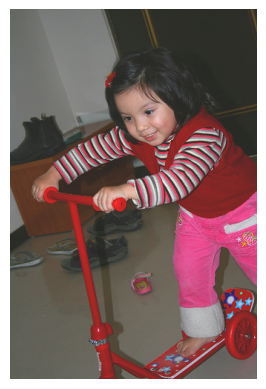

Caption # 0 :  <unk>s<unk> people are walking by water.</s> of a subway ringi.</s>n day.</s> holding their heads.</s>.</s> of coffee winter it.</s>.</s> held for it through two others dancing.</s>.</s> and others.</s>.</s> paved behind them near the end of art.</s>.</s> water x.</s> style of three mirror.</s>.</s>.</s>.</s>.</s>.</s> to a young blond-b.</s> camera.</s>.</s> on it.</s> 


Caption # 1 :  <unk>s<unk> boys and two women are walking on stage.</s>.</s>.</s> to and singing.</s>.</s>.</s>.</s>.</s> day.</s>.</s>.</s>.</s> chin.</s> the most of a seafood.</s>.</s>.</s>.</s>ia.</s>.</s>.</s> setting stick.</s> side of the same of autumn with a backlit noses reflection</s>.</s> branch.</s>.</s> jug in front of others.</s> cart.</s>-green.</s> sign of a bottle 


Caption # 2 :  <unk>s<unk> children are runninging a building.</s>-haired person in snow.</s> on the waves.</s>.</s>.</s> grass.</s>.</s>, toes horse.</s>.</s>ing plants.</s>i step by the playground.</s>.</s>ing a grassy 

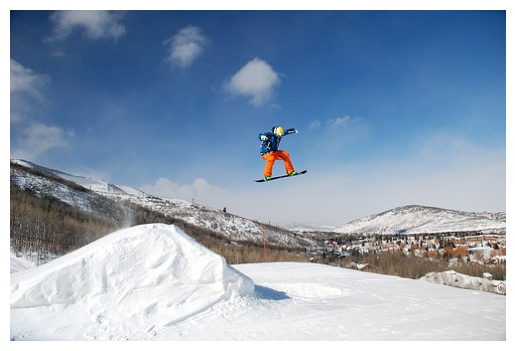

Caption # 0 :  <unk>s<unk> Con stand in a hand and white shirt with a yellow life onto a cafeteria.</s>.</s> building.</s> cane.</s> recent the ground's the water.</s> stand.</s>.</s> right.</s>.</s> and a decorative.</s>.</s> on the ground.</s> a coffee is siting day.</s>.</s>n collage.</s> wearing a street.</s>.</s>.</s> while a large harmonica in the ground.</s>.</s> with his knees.</s> in the track on the 


Caption # 1 :  <unk>s<unk>ariousbody, one girl run and white, possibly in blue appears while holding a boat nearby walk by the same fri.</s>.</s>.</s> leaves.</s> a colorfuls.</s> view look of strip with a white garment behind him.</s> have on wearing all of them.</s> to one of them pool.</s>, and her head.</s> of a cute.</s> talks.</s> of his face.</s>.</s>ed.</s> hour.</s> in front of him.</s> pants, and 


Caption # 2 :  <unk>s<unk> people wait a tent in a class.</s> shapeein papers.</s>.</s>d.</s> and a microphone.</s> through the air course that Republic label are looking 

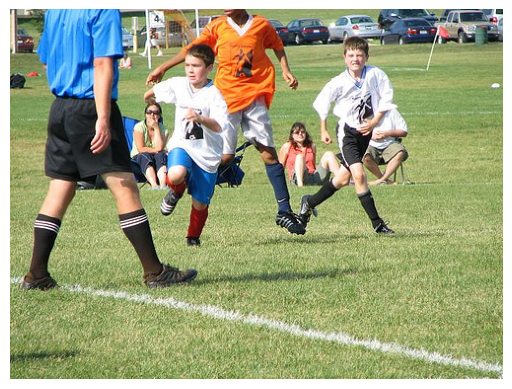

Caption # 0 :  <unk>s<unk> all are watching a ball on a park.</s>ing two ground.</s> vehicle.</s> filled.</s>.</s>.</s> water.</s>-shirt.</s>.</s> table.</s>.</s>.</s> school.</s> bike in front of a large green grass.</s>.</s>.</s> another woman wearing a book.</s>ro and salmon watching a short with some sort and laughing.</s> her to rope on it while sitting and another person are carrying her hands.</s>.</s>.</s>ing place 


Caption # 1 :  <unk>s<unk> thaning clay at a ramp.</s>.</s>.</s> competitions plane</s>.</s>" at the camera.</s>.</s> table block while holding a staff.</s>.</s>d.</s>d parentsre.</s>.</s> tree.</s>.</s> container friends drive award.</s> nearby.</s>.</s> man is pointing in a blue bow seat broom.</s>.</s>.</s> on top.</s>.</s> excitement.</s> rink.</s>.</s>.</s> behind him.</s>.</s> in 


Caption # 2 :  <unk>s<unk> people walking along a cherry.</s>, wearing black jeans and blue shirt, and green jersey in yellow helmets.</s> are playing a storeed cloudless is read

In [44]:
import random
with torch.no_grad():
    model.eval()
    
    for file in validation_data:
        valid_captionDataset = CaptionDataset(file, image_side, patch_side, sp, device, True)
        for attempt in range(5):
            random_index = random.randint(0, len(valid_captionDataset) - 1)
            image, imagesTokens, captionsInputs, captionsTargets = valid_captionDataset[random_index]
            
            nparr = np.frombuffer(image['bytes'], np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            plt.axis('off')  # Hide axis
            plt.show()
    
            for J in range(3):
                startCaption = "<s>"
                startTokensIds = sp.EncodeAsIds(startCaption) 
                startTokensTensor = torch.tensor(startTokensIds, dtype=torch.long, device = device).unsqueeze(0)   # [1 x int, ..., tokens_length] 
                finalCaptionTokensIds = startTokensIds
                
                for i in range(maxNewTokens):
    
                    genLogits  = model(imagesTokens.unsqueeze(0), startTokensTensor)               # Size: [Batch Size x Caption Tokens Amount x vocab_size]
                    # Let's focus only on last token in sequence
                    genLogits = genLogits[:, -1, :]                                 # Size: [Batch Size x Vocab Size]  
                    probabilities = F.softmax(genLogits, dim=-1)                    # Size: [Batch Size x Vocab Size], Probavilities of each word from vocab
                    nextIdx = torch.multinomial(probabilities, num_samples = 1)     # Size: [Batch Size x 1]
                    
                    # apply running index to the running sequence 
                    startTokensTensor = torch.cat((startTokensTensor, nextIdx), dim=1) # Size: [Batch Size x (Tokens Amount + 1)]
                    finalCaptionTokensIds.append(nextIdx.item())
                    finalStoryTokens = []
                    for tokenId in finalCaptionTokensIds:
                        finalStoryTokens.append(sp.IdToPiece(tokenId))
               
                finalStory = ''.join(finalStoryTokens).replace('▁', ' ').strip()  # Assuming '▁' is the SentencePiece underline character
                print("Caption #", J, ": ", finalStory, "\n\n")

       
                
        
        
                
                

    model.train()